### Задачи:

1. Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение? Насколько обучение сокращает время прохождения этапов?

2. Существует ли зависимость между вероятностью оплаты тренировки и количеством обучений, которые начинал или завершал пользователь.

* Как часто пользователи начинают обучение после того, как они выбрали уровень сложности тренировок? (Это позволит нам понять, насколько процесс работы с приложением понятен для пользователей: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [103]:
import pandas as pd
import psycopg2
import psycopg2.extras 
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def getEventsData():
    query = '''SELECT e.* FROM case8.events e
    WHERE e.user_id in
    (SELECT DISTINCT(user_id) 
    FROM case8.events 
    WHERE event_type = 'registration' 
    AND start_time >= '2018-01-01'
    AND start_time < '2019-01-01')
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

def getPurchaseData():
    query = '''SELECT p.* FROM case8.purchase p
    WHERE p.user_id in
    (SELECT DISTINCT(user_id) 
    FROM case8.events 
    WHERE event_type = 'registration' 
    AND start_time >= '2018-01-01'
    AND start_time < '2019-01-01')
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

events_df = pd.DataFrame(getEventsData())
purchase_df = pd.DataFrame(getPurchaseData())

In [195]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82779 entries, 0 to 82778
Data columns (total 6 columns):
event_type        82779 non-null object
selected_level    10198 non-null object
start_time        82779 non-null datetime64[ns]
tutorial_id       41201 non-null float64
user_id           82779 non-null int64
event_id          82779 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [196]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 5 columns):
user_id        1974 non-null int64
start_time     1974 non-null datetime64[ns]
amount         1974 non-null int64
purchase_id    1974 non-null int64
event_type     1974 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 77.2+ KB


### Гипотеза №1

In [4]:
# пользователи, которые прошли обучение
set_tutorial_users_finish = set(events_df[events_df['event_type'] == 'tutorial_finish']['user_id'].unique())
len(set_tutorial_users_finish)

12531

In [5]:
# пользователи, которые начинали обучение
set_tutorial_users_start = set(events_df[events_df['event_type'] == 'tutorial_start']['user_id'].unique())

# пользователи, которые не начинали обучение
set_all_users = set(events_df['user_id'].unique())
set_not_start_tutorial_users = set_all_users.difference(set_tutorial_users_start)
len(set_not_start_tutorial_users)

9909

#### Определим пути пользователей

In [6]:
events_df = events_df.rename(columns={'id':'event_id'})
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
purchase_df['event_type'] = 'purchase'

In [7]:
total_events_df = pd.concat([events_df, purchase_df],sort=False)

In [8]:
# исключим из рассмотрения пользователей, которые не пользуются приложением, а только зарегистрировались
total_events_df = total_events_df[total_events_df['event_type'] != 'registration']
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df.head()

,event_type,selected_level,start_time,tutorial_id,user_id,event_id,amount,purchase_id
0,tutorial_start,None,2018-01-01 13:55:11,49555.0,47758,147273.0,NaN,NaN
1,tutorial_start,None,2018-01-01 13:56:40,49556.0,47761,147274.0,NaN,NaN
2,tutorial_finish,None,2018-01-01 13:59:44,49556.0,47761,147275.0,NaN,NaN
3,tutorial_start,None,2018-01-01 14:45:21,49557.0,47760,147278.0,NaN,NaN
4,tutorial_finish,None,2018-01-01 14:51:15,49557.0,47760,147279.0,NaN,NaN


In [9]:
user_path_df = total_events_df.groupby(['user_id'])['event_type'].apply(list).reset_index()

In [10]:
user_path_df.head(10)

,user_id,event_type
0,47758,[tutorial_start]
1,47759,"[tutorial_start, tutorial_finish, level_choice..."
2,47760,"[tutorial_start, tutorial_finish, level_choice]"
3,47761,"[tutorial_start, tutorial_finish, level_choice..."
4,47765,[tutorial_start]
5,47766,"[tutorial_start, tutorial_finish, level_choice..."
6,47768,"[tutorial_start, tutorial_finish, level_choice..."
7,47769,"[tutorial_start, tutorial_finish]"
8,47770,"[tutorial_start, tutorial_finish]"
9,47771,"[tutorial_start, tutorial_finish, level_choice..."


In [36]:
user_path_df['event_path'] = user_path_df['event_type'].apply(lambda x: ' > '.join(x))
user_path_df['event_path'].head()

0                                       tutorial_start
1    tutorial_start > tutorial_finish > level_choic...
2      tutorial_start > tutorial_finish > level_choice
3    tutorial_start > tutorial_finish > level_choic...
4                                       tutorial_start
Name: event_path, dtype: object

In [12]:
user_paths = user_path_df.groupby(['event_path'])['user_id'].nunique().sort_values(ascending=False)

In [13]:
user_paths.head(20)

event_path
tutorial_start > tutorial_finish > level_choice > training_choice                                                  3248
tutorial_start > tutorial_finish                                                                                   2425
tutorial_start > tutorial_finish > level_choice                                                                    2133
tutorial_start > tutorial_finish > level_choice > training_choice > purchase                                       1295
tutorial_start                                                                                                     1026
tutorial_start > level_choice > training_choice                                                                     439
tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                                 373
tutorial_start > level_choice                                                                                       320
tutorial_start > tutorial_fin

#### Выводы по этапам: 
А. Можно наблюдать, что бОльшая часть пользоваталей после регистрации начинает обучение.

Б. Т.к. сравниваем времена этапов пользователей, которые прошли обучение и пользователей, не начинавших обучение, а для пользователей только начавших обучение (но не закончивших) мы не знаем количество времени, потраченное на обучение, то выберем для валидации / опровержения гипотезы следующие этапы:

1. Выбор уровня (level_choice) - Выбор тренировок (training_choice);
2. Выбор тренировок (training_choice) - покупка (purchase).

#### Среднее время между "Выбор уровня" и "Выбор тренировок"

##### Пользователи не начинавшие обучение

In [14]:
not_start_tut_level_choice_df = total_events_df[['user_id', 'start_time', 'event_type']]
not_start_tut_level_choice_df = not_start_tut_level_choice_df[not_start_tut_level_choice_df['user_id'].isin(set_not_start_tutorial_users)]
not_start_tut_level_choice_df = not_start_tut_level_choice_df[not_start_tut_level_choice_df['event_type'] == 'level_choice']
not_start_tut_level_choice_df = not_start_tut_level_choice_df[['user_id', 'start_time']]
not_start_tut_level_choice_df = not_start_tut_level_choice_df.rename(columns = {'start_time': 'level_choice_time'})

not_start_tut_training_choice_df = total_events_df[['user_id', 'start_time', 'event_type']]
not_start_tut_training_choice_df = not_start_tut_training_choice_df[(not_start_tut_training_choice_df['user_id'].isin(set_not_start_tutorial_users))]
not_start_tut_training_choice_df = not_start_tut_training_choice_df[not_start_tut_training_choice_df['event_type'] == 'training_choice']
not_start_tut_training_choice_df = not_start_tut_training_choice_df[['user_id', 'start_time']]
not_start_tut_training_choice_df = not_start_tut_training_choice_df.rename(columns = {'start_time': 'training_choice_time'})

merged_df_1_1 = not_start_tut_level_choice_df.merge(not_start_tut_training_choice_df, how = 'inner', on = 'user_id')
merged_df_1_1.head()

,user_id,level_choice_time,training_choice_time
0,48136,2018-01-10 18:32:43,2018-01-10 18:39:16
1,48572,2018-01-17 04:19:46,2018-01-17 04:23:14
2,48775,2018-01-19 14:38:07,2018-01-19 14:46:09
3,48769,2018-01-19 18:10:09,2018-01-19 18:15:50
4,49495,2018-01-30 23:52:18,2018-01-30 23:54:50


In [15]:
merged_df_1_1['time_delta'] = merged_df_1_1['training_choice_time'] - merged_df_1_1['level_choice_time']

In [16]:
merged_df_1_1.describe()

,user_id,time_delta
count,77.000000,77
mean,59180.337662,0 days 00:05:31.077922
std,6783.482836,0 days 00:02:46.163027
min,48136.000000,0 days 00:00:11
25%,53221.000000,0 days 00:03:21
50%,58241.000000,0 days 00:05:13
75%,65383.000000,0 days 00:07:28
max,71173.000000,0 days 00:11:49


##### Пользователи прошедшие обучение полностью

In [17]:
finish_tut_level_choice_df = total_events_df[['user_id', 'start_time', 'event_type']]
finish_tut_level_choice_df = finish_tut_level_choice_df[finish_tut_level_choice_df['user_id'].isin(set_tutorial_users_finish)]
finish_tut_level_choice_df = finish_tut_level_choice_df[finish_tut_level_choice_df['event_type'] == 'level_choice']
finish_tut_level_choice_df = finish_tut_level_choice_df[['user_id', 'start_time']]
finish_tut_level_choice_df = finish_tut_level_choice_df.rename(columns = {'start_time': 'level_choice_time'})

finish_tut_training_choice_df = total_events_df[['user_id', 'start_time', 'event_type']]
finish_tut_training_choice_df = finish_tut_training_choice_df[(finish_tut_training_choice_df['user_id'].isin(set_tutorial_users_finish))]
finish_tut_training_choice_df = finish_tut_training_choice_df[finish_tut_training_choice_df['event_type'] == 'training_choice']
finish_tut_training_choice_df = finish_tut_training_choice_df[['user_id', 'start_time']]
finish_tut_training_choice_df = finish_tut_training_choice_df.rename(columns = {'start_time': 'training_choice_time'})

merged_df_1_2 = finish_tut_level_choice_df.merge(finish_tut_training_choice_df, how = 'inner', on = 'user_id')
merged_df_1_2.head()

,user_id,level_choice_time,training_choice_time
0,47761,2018-01-01 15:05:04,2018-01-01 15:12:25
1,47768,2018-01-01 18:44:32,2018-01-01 18:46:24
2,47759,2018-01-01 20:05:14,2018-01-01 20:06:57
3,47766,2018-01-02 00:07:39,2018-01-02 00:15:02
4,47779,2018-01-02 04:48:02,2018-01-02 04:51:24


In [18]:
merged_df_1_2['time_delta'] = merged_df_1_2['training_choice_time'] - merged_df_1_2['level_choice_time']
merged_df_1_2.head()

,user_id,level_choice_time,training_choice_time,time_delta
0,47761,2018-01-01 15:05:04,2018-01-01 15:12:25,00:07:21
1,47768,2018-01-01 18:44:32,2018-01-01 18:46:24,00:01:52
2,47759,2018-01-01 20:05:14,2018-01-01 20:06:57,00:01:43
3,47766,2018-01-02 00:07:39,2018-01-02 00:15:02,00:07:23
4,47779,2018-01-02 04:48:02,2018-01-02 04:51:24,00:03:22


In [19]:
merged_df_1_2.describe()

,user_id,time_delta
count,6211.000000,6211
mean,59926.550153,0 days 00:05:09.668813
std,7087.088617,0 days 00:02:43.241217
min,47759.000000,0 days 00:00:15
25%,53804.000000,0 days 00:02:56
50%,59938.000000,0 days 00:04:47
75%,66064.000000,0 days 00:07:01
max,72216.000000,0 days 00:15:35


#### Промежуточные итоги:
Среднее время данного этапа:
    - у пользователей, которые прошли полностью обучение: 5:09 мин;
    - у пользователей, которые не начинали обучение: 5:31 мин.

#### Среднее время между "Выбор тренировок" и "Покупка"

##### Пользователи не начинавшие обучение

In [20]:
not_start_tut_purchase_df = total_events_df[['user_id', 'start_time', 'event_type']]
not_start_tut_purchase_df = not_start_tut_purchase_df[not_start_tut_purchase_df['user_id'].isin(set_not_start_tutorial_users)]
not_start_tut_purchase_df = not_start_tut_purchase_df[not_start_tut_purchase_df['event_type'] == 'purchase']
not_start_tut_purchase_df = not_start_tut_purchase_df[['user_id', 'start_time']]
not_start_tut_purchase_df = not_start_tut_purchase_df.rename(columns = {'start_time': 'purchase_time'})

merged_df_2_1 = not_start_tut_training_choice_df.merge(not_start_tut_purchase_df, how = 'inner', on = 'user_id')
merged_df_2_1.head()

,user_id,training_choice_time,purchase_time
0,48775,2018-01-19 14:46:09,2018-01-25 09:50:29
1,50081,2018-02-07 17:38:42,2018-02-11 19:24:53
2,50186,2018-02-09 01:17:48,2018-02-11 18:00:25
3,50528,2018-02-14 02:18:24,2018-02-19 16:05:26
4,55267,2018-04-26 12:54:07,2018-05-04 21:18:32


In [21]:
merged_df_2_1['time_delta'] = merged_df_2_1['purchase_time'] - merged_df_2_1['training_choice_time']


In [22]:
merged_df_2_1.describe()

,user_id,time_delta
count,18.000000,18
mean,59353.000000,3 days 23:07:16.111111
std,6877.261202,1 days 22:59:05.990710
min,48775.000000,1 days 00:16:58
25%,55305.750000,2 days 08:16:01
50%,58777.000000,3 days 17:44:32.500000
75%,65360.750000,5 days 07:25:03.750000
max,69573.000000,8 days 08:24:25


##### Пользователи прошедшие обучение

In [23]:
finish_tut_purchase_df = total_events_df[['user_id', 'start_time', 'event_type']]
finish_tut_purchase_df = finish_tut_purchase_df[finish_tut_purchase_df['user_id'].isin(set_tutorial_users_finish)]
finish_tut_purchase_df = finish_tut_purchase_df[finish_tut_purchase_df['event_type'] == 'purchase']
finish_tut_purchase_df = finish_tut_purchase_df[['user_id', 'start_time']]
finish_tut_purchase_df = finish_tut_purchase_df.rename(columns = {'start_time': 'purchase_time'})

merged_df_2_2 = finish_tut_training_choice_df.merge(finish_tut_purchase_df, how = 'inner', on = 'user_id')
merged_df_2_2.head()

,user_id,training_choice_time,purchase_time
0,47779,2018-01-02 04:51:24,2018-01-07 12:48:08
1,47771,2018-01-02 14:27:54,2018-01-03 07:30:09
2,47794,2018-01-02 20:57:30,2018-01-08 01:51:07
3,47791,2018-01-02 21:37:55,2018-01-03 16:53:34
4,47797,2018-01-02 21:43:26,2018-01-07 12:59:01


In [24]:
merged_df_2_2['time_delta'] = merged_df_2_2['purchase_time'] - merged_df_2_2['training_choice_time']

In [25]:
merged_df_2_2.describe()

,user_id,time_delta
count,1781.000000,1781
mean,59971.539585,3 days 16:59:07.005614
std,7052.247974,2 days 03:37:52.042729
min,47771.000000,0 days 01:31:41
25%,53858.000000,1 days 22:51:29
50%,59981.000000,3 days 12:22:50
75%,65988.000000,5 days 06:56:21
max,72205.000000,10 days 07:56:10


#### Промежуточные итоги:
Среднее время данного этапа:
    - у пользователей, которые прошли полностью обучение: 3 дня 23:07:16;
    - у пользователей, которые не начинали обучение: 3 дня 16:59:07.

In [120]:
# функция расчета секунд в типе данных timedelta
def timedelta_to_seconds(timedelta):
    timedelta = str(timedelta).split(' ')
    days = int(timedelta[0])
    time = timedelta[2].split(':')
    hours = int(time[0])
    minutes = int(time[1])
    seconds = float(time[2])
    return days * 24 * 60 * 60 + hours * 60 * 60 + minutes * 60 + seconds

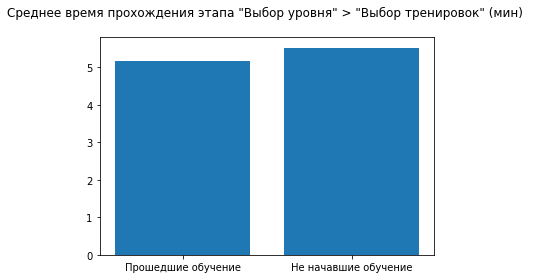

In [173]:
avg_delta_not_start_tut_lvl_train = timedelta_to_seconds(merged_df_1_1['time_delta'].mean())
avg_delta_tut_finish_lvl_train = timedelta_to_seconds(merged_df_1_2['time_delta'].mean())

x1 = ['Прошедшие обучение', 'Не начавшие обучение']
y1 = [avg_delta_tut_finish_lvl_train / 60, avg_delta_not_start_tut_lvl_train / 60]
ax1 = plt.gca()
ax1.bar(x1, y1)
ax1.set_title('Среднее время прохождения этапа "Выбор уровня" > "Выбор тренировок" (мин) \n')

plt.show()

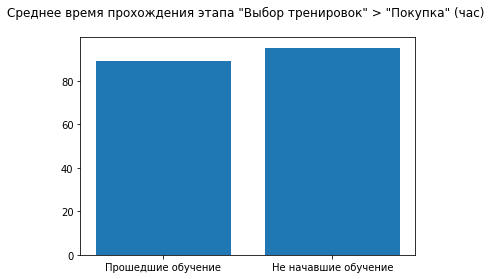

In [175]:
avg_delta_not_start_tut_train_purchase = timedelta_to_seconds(merged_df_2_1['time_delta'].mean())
avg_delta_tut_finish_train_purchase = timedelta_to_seconds(merged_df_2_2['time_delta'].mean())

x2 = ['Прошедшие обучение', 'Не начавшие обучение']
y2 = [avg_delta_tut_finish_train_purchase / 3600, avg_delta_not_start_tut_train_purchase / 3600]
ax2 = plt.gca()
ax2.bar(x2, y2)
ax2.set_title('Среднее время прохождения этапа "Выбор тренировок" > "Покупка" (час) \n')

plt.show()

### Итоги по Гипотезе №1:

Среднее время этапа "Выбор уровня" и "Выбор тренировок":
- у пользователей, которые прошли полностью обучение: 00:05:09, медиана: 00:04:47;
- у пользователей, которые не начинали обучение: 00:05:31, медиана:  00:05:31.


Среднее время этапа "Выбор тренировок" и "Покупка":
- у пользователей, которые прошли полностью обучение: 3 дня 23:07:16, медиана: 3 дня 16:59:07;
- у пользователей, которые не начинали обучение: 3 дня 16:59:07, медиана: 3 дня 17:44:32.

Соответственно, можно сделать вывод о том, что обучение обучение мало влияет на скорость прохождения.
Соответственно: либо требуется повышать эффективность обучения, либо программа составлена с высокой степенью проработки UX (user experience), что позволяет пользователям разбираться в этапах программы самостоятельно.


### Гипотеза №2

In [26]:
total_events_df

,event_type,selected_level,start_time,tutorial_id,user_id,event_id,amount,purchase_id
0,tutorial_start,None,2018-01-01 13:55:11,49555.0,47758,147273.0,NaN,NaN
1,tutorial_start,None,2018-01-01 13:56:40,49556.0,47761,147274.0,NaN,NaN
2,tutorial_finish,None,2018-01-01 13:59:44,49556.0,47761,147275.0,NaN,NaN
3,tutorial_start,None,2018-01-01 14:45:21,49557.0,47760,147278.0,NaN,NaN
4,tutorial_finish,None,2018-01-01 14:51:15,49557.0,47760,147279.0,NaN,NaN
...,...,...,...,...,...,...,...,...
60237,purchase,NaN,2019-01-06 07:08:00,NaN,72172,NaN,50.0,20418.0
58706,purchase,NaN,2019-01-06 07:36:11,NaN,72212,NaN,50.0,20419.0
59148,purchase,NaN,2019-01-06 10:53:03,NaN,72197,NaN,200.0,20421.0
60098,purchase,NaN,2019-01-06 23:26:44,NaN,72169,NaN,50.0,20424.0


In [27]:
tut_purch_df = total_events_df[['event_type', 'user_id', 'amount']]
# оставим только успешные прохождения, как писал Сергей "...если пользователь ПРОХОДИЛ обучение несколько раз..." и факты оплат
tut_purch_df = tut_purch_df[(tut_purch_df['event_type'] == 'tutorial_finish') | (tut_purch_df['event_type'] == 'purchase')]
tut_purch_df.head()

,event_type,user_id,amount
2,tutorial_finish,47761,NaN
4,tutorial_finish,47760,NaN
9,tutorial_finish,47768,NaN
11,tutorial_finish,47759,NaN
18,tutorial_finish,47768,NaN


In [28]:
arr_users = tut_purch_df['user_id'].unique()
count_pivot = pd.pivot_table(tut_purch_df, values = ['amount', 'event_type'], columns = 'event_type', index = 'user_id', \
                             aggfunc = {'amount': np.sum, 'event_type': 'count'}, fill_value=0)

In [29]:
# удалим лишнее
count_df = pd.DataFrame(count_pivot)
count_df = count_df.reset_index()
count_df = count_df.drop(count_df.columns[[2, 3]], axis = 'columns')

In [30]:
count_df.columns = ['user_id', 'amount', 'tutorial_finish_counter']
count_df.head(10)

,user_id,amount,tutorial_finish_counter
0,47759,0,1
1,47760,0,1
2,47761,0,1
3,47766,0,1
4,47768,0,2
5,47769,0,1
6,47770,0,1
7,47771,50,1
8,47775,0,1
9,47779,50,1


In [31]:
count_df = count_df.sort_values(by = ['tutorial_finish_counter'], ascending = True)
count_df.head(10)

,user_id,amount,tutorial_finish_counter
1477,50572,50,0
6342,59871,100,0
4381,56141,50,0
9389,65796,50,0
12422,71617,50,0
4694,56737,100,0
3718,54891,150,0
5905,59025,150,0
590,48865,150,0
7133,61393,100,0


In [32]:
#исключаем все 'tutorial_finish_counter' == 0, т.к. это пользователи не прошедшие обучение ни разу (только оплатившие)
count_df = count_df[count_df['tutorial_finish_counter'] != 0]
count_df['amount_payments'] = count_df['amount']
count_df.head(10)

,user_id,amount,tutorial_finish_counter,amount_payments
7875,62867,0,1,0
8187,63437,100,1,100
7944,62995,0,1,0
8188,63438,0,1,0
8166,63402,25,1,25
7873,62860,0,1,0
7895,62897,0,1,0
8167,63403,0,1,0
7942,62990,0,1,0
8169,63407,50,1,50


#### Расчитаем вероятности  оплаты в зависимости от количества пройденных обучений (в виде сводной таблицы)

In [33]:
count_pivot_2 = pd.pivot_table(count_df, values = ['amount', 'user_id', 'amount_payments'], index = 'tutorial_finish_counter',\
                             aggfunc = {'amount': np.count_nonzero, 'user_id': 'count', 'amount_payments': np.sum})
count_pivot_2.columns = ['sum_payments','avg_payment', 'sum_users']
count_pivot_2['payments, %'] = (count_pivot_2['sum_payments'] / count_pivot_2['sum_users']) * 100
count_pivot_2['avg_payment'] = count_pivot_2['avg_payment'] / count_pivot_2['sum_payments']
count_pivot_2 = count_pivot_2[['sum_payments', 'sum_users', 'avg_payment', 'payments, %']]
count_pivot_2.head(10)

,sum_payments,sum_users,avg_payment,"payments, %"
tutorial_finish_counter,,,,
1,1366,9721,108.986091,14.052052
2,235,1599,107.872340,14.696685
3,68,430,106.985294,15.813953
4,34,231,101.470588,14.718615
5,22,166,114.772727,13.253012
6,25,166,88.000000,15.060241
7,16,126,75.000000,12.698413
8,10,65,125.000000,15.384615
9,5,27,70.000000,18.518519


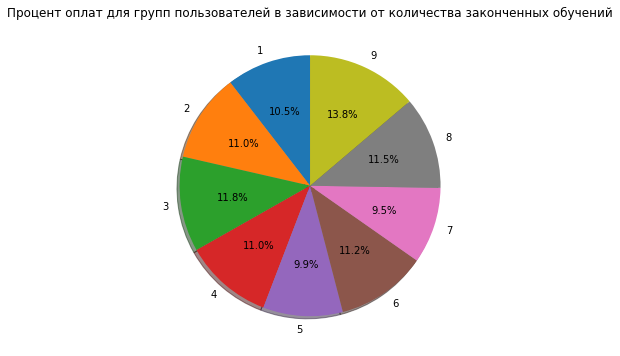

In [194]:
labels = count_pivot_2.index
values = count_pivot_2['payments, %']

fig3, ax3 = plt.subplots()
ax3.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig3.set_size_inches(6, 6)
ax3.set_title('Процент оплат для групп пользователей в зависимости от количества законченных обучений')

plt.show()

### Итоги по Гипотезе №2:
На основании анализа по группам пользователей, которые прошли обучение от 1 до 9 раз можно сделать заключение о том, что средняя сумма трат пользователя в приложении мало отличается от количества пройденных обучений.
Такой же вывод можно сделать по проценту плативших пользователей - нет зависимости между количеством пройденных обучений и фактом оплаты.

### Гипотеза №3

In [34]:
# найдем количество путей "level_choice > tutorial_start"
user_paths_level_choice_tutorial = user_paths[user_paths.index.str.contains('level_choice > tutorial_start')]
user_paths_level_choice_tutorial.head()

event_path
tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                                                          233
tutorial_start > tutorial_finish > level_choice > tutorial_start                                                                                             44
tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                        24
tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                        22
tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish      9
Name: user_id, dtype: int64

#### Процент таких "путей"

In [37]:
percent_level_choice_tutorial = user_paths_level_choice_tutorial.sum() / user_paths.sum()
print('Количество пользователей, которые сначала выбрали уровень сложности, \
а затем начали обучение: {}'.format(user_paths_level_choice_tutorial.sum()))
print('Процент количества пользователей, которые сначала выбрали уровень сложности,\
а затем начали обучение: {:.2%}'.format(percent_level_choice_tutorial))

Количество пользователей, которые сначала выбрали уровень сложности, а затем начали обучение: 601
Процент количества пользователей, которые сначала выбрали уровень сложности,а затем начали обучение: 4.10%


### Итоги по Гипотезе №3:
4% пользователей, которые сначала выбрали уровень сложности, а затем начали обучение. Также стоит отметить, что большая часть этих пользователей уже ранее проходила полностью обучение, но решила снова перепройти его / нажала на начало обучения случайно. В любом случае проработка обучения по причине низкой эффективности скорее не требуется.